In [5]:
import os
import re
import sys
import argparse
import subprocess
import matplotlib
import time
import pandas as pd
import numpy as np
from itertools import groupby
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle
#from IPython.core.display import display, HTML
#display(HTML("<style>.output_wrapper, .output {    height:auto !important;max-height:1000px;  /* your desired max-height here */}.output_scroll {    box-shadow:none !important;    webkit-box-shadow:none !important;}</style>"))

import seaborn as sns

In [6]:
#all cook things
os.chdir("/home/pavel-kravchenko/")

def init_paths():
    root = os.getcwd() # просто корень
    control = os.path.abspath('/home/ilya/hocomoco11/control/control/') # данные контроля
    train = os.path.abspath('train/') # данные для обучения
    basicdir = os.path.abspath('result/') # директория для общих файлов
    outputdir = os.path.abspath('result/outputdir') # директория для подготовки данных
    pwmdir = os.path.abspath('/home/ilya/hocomoco11/models/pwm/mono/all') # здесь лежат все PWM каждая в своей директории
    print("Input dirs:", control, "\n", train, "\n",basicdir, "\n", pwmdir)
    print("")
    
    if not os.path.exists(basicdir):
        os.makedirs(basicdir)
    if not os.path.exists(outputdir):
        os.makedirs(outputdir)
    
    files_mfa = [f for f in os.listdir(train) if os.path.splitext(f)[1] == '.mfa']
    files_pwm = []
    for d in os.listdir(pwmdir):
        #print(d)
        d = pwmdir + "/" + d
        if os.path.isdir(d):
            os.chdir(d)
            files_pwm.append([f for f in os.listdir(os.getcwd()) if os.path.splitext(f)[1] == '.pwm'])
        os.chdir(pwmdir)
    return root, control, train, outputdir, pwmdir, files_mfa, files_pwm, basicdir

root, control, train, outputdir, pwmdir, files_mfa, files_pwm, basicdir = init_paths()

#!pwd

#print("files_mfa:", files_mfa)
#print("We have {N} directories".format(N=len(files_pwm)))
#print("files_pwm:", files_pwm[:10])


# пишем проверку 
def remove_duplicates(l):
    return list(set(l))

def check(in_list): # берем все файлы
    print("We have {N} sequences".format(N=len(remove_duplicates([x[0].split("~")[2].split(".")[0].split("_")[0] for x in in_list]))))
    collection_list = []
    for i in in_list:
        #print(i)
        exp = [x.split("~")[2].split(".")[1] for x in i] 
        d = {}
        for j in exp:
            if j in d.keys(): # делаем словарь из экспериментов
                d[j] += 1
            else:
                d[j] = 1
        #print(d)
        if len(d.keys()) >= 2: #Берем только те TF, в которых больше двух экспериментов
            collection_list.append(i)
    #print(collection_list[:10])
    
    dict_of_names = {}
    for i in collection_list:
        i = i[0].split("~")[2].split(".")[0].split("_")[0]
        #print(i)
        if i in dict_of_names.keys():
            dict_of_names[i] += 1
        else:
            dict_of_names[i] = 1
            
    good_names_list = []  # получили лист с TF, которые встречаются у мыши и человека
    for i in dict_of_names.keys():
        if dict_of_names[i] >= 2:
            good_names_list.append(i)
           
    #print(good_names_list[:10])
    out_list = []    
    for i in collection_list:
        if i[0].split("~")[2].split(".")[0].split("_")[0] in good_names_list:
            #print(len(i))
            out_list.append(i)
            
    selected_short_names_list = remove_duplicates([x[0].split("~")[2].split(".")[0].split("_")[0] for x in out_list])
    selected_full_names_list = [x[0].split("~")[2].split(".")[0] for x in out_list]
    print("We got {N} sequences".format(N=len(selected_short_names_list)))
    return out_list, selected_short_names_list, selected_full_names_list

new_files_pwm, selected_short_names_list, selected_full_names_list = check(files_pwm)
#print(new_files_pwm)
#print(selected_names_list)

selected_HUMAN = selected_full_names_list[::2]
selected_MOUSE = selected_full_names_list[1::2]


Input dirs: /home/ilya/hocomoco11/control/control 
 /home/pavel-kravchenko/train 
 /home/pavel-kravchenko/result 
 /home/ilya/hocomoco11/models/pwm/mono/all

We have 835 sequences
We got 211 sequences


Sarus is running...
Selected_full_names_list: 422
factor # 0 of 422
 
dirname is: ANDR_HUMAN
['ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033090.macs.M.pwm', 'ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033090.macs.S.pwm', 'ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033090.pics.M.pwm', 'ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033090.pics.S.pwm', 'ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033090.sissrs.M.pwm']
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033090.macs.M.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab'] 1
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab ) >> out_sure.csv
group_selection is running for ANDR_HUMAN
1000 321165
data_splitting is running
(322165, 1) (322165,)
(225515, 1) (96650, 1)
(225515,) (96650,)
model_building is running
Accuracy: 99.72%
Precision : 66.67%
Recall score: 0.72%
roc_auc_score 0.7175109318978627
average_precision_score 0.030574018379098553
rocauc_plotting is running


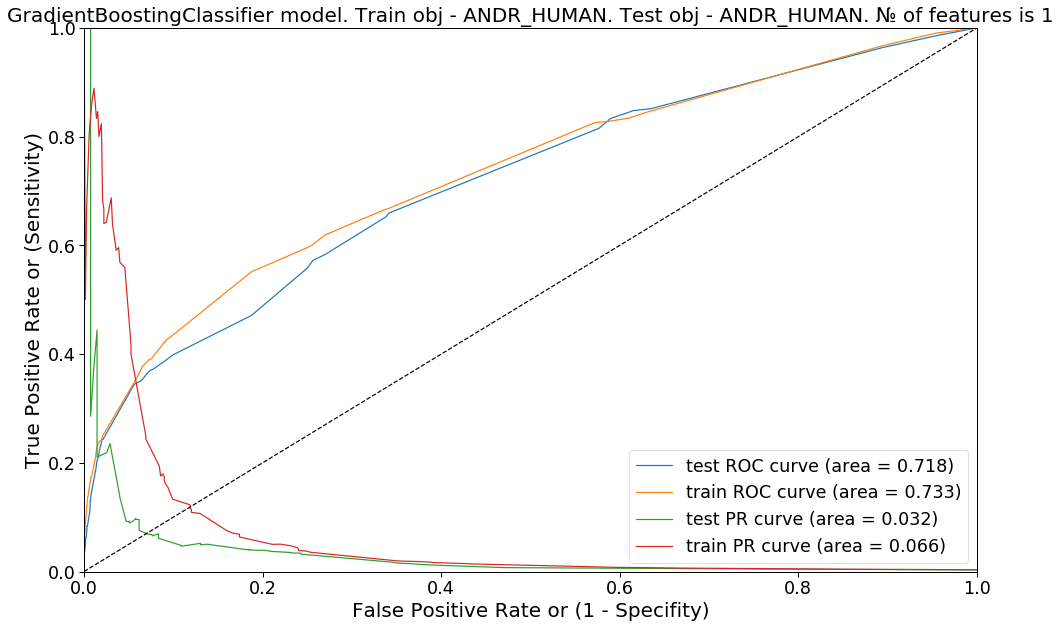

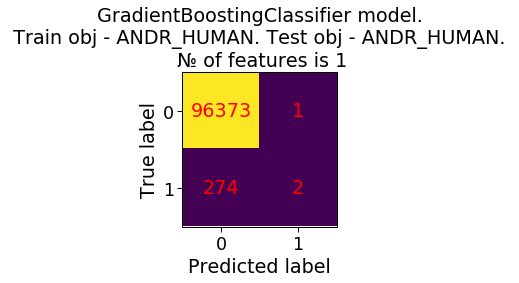

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033090.macs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033090.pics.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033090.pics.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033090.sissrs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033090.sissrs.S.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_pics_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_pics_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_sissrs_M_feature_compare_table_cut.tab'] 6
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_pics_M_fea

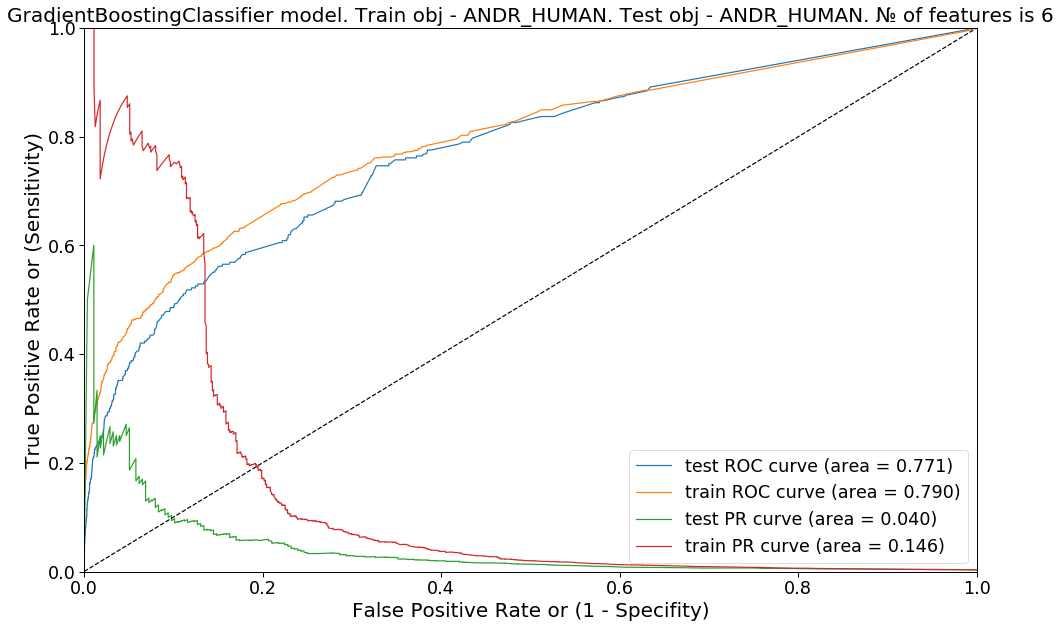

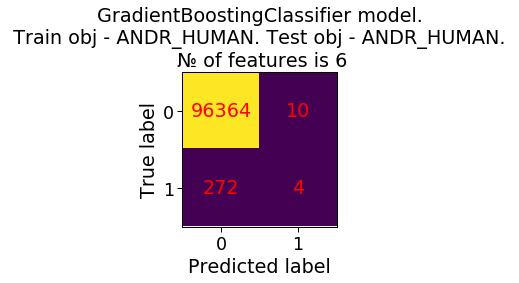

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033109.gem.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033109.gem.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033109.macs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033109.macs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033109.pics.M.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_pics_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_pics_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_sissrs_M_feature_compare_table_cut.tab'] 11
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_pics_M_feature_

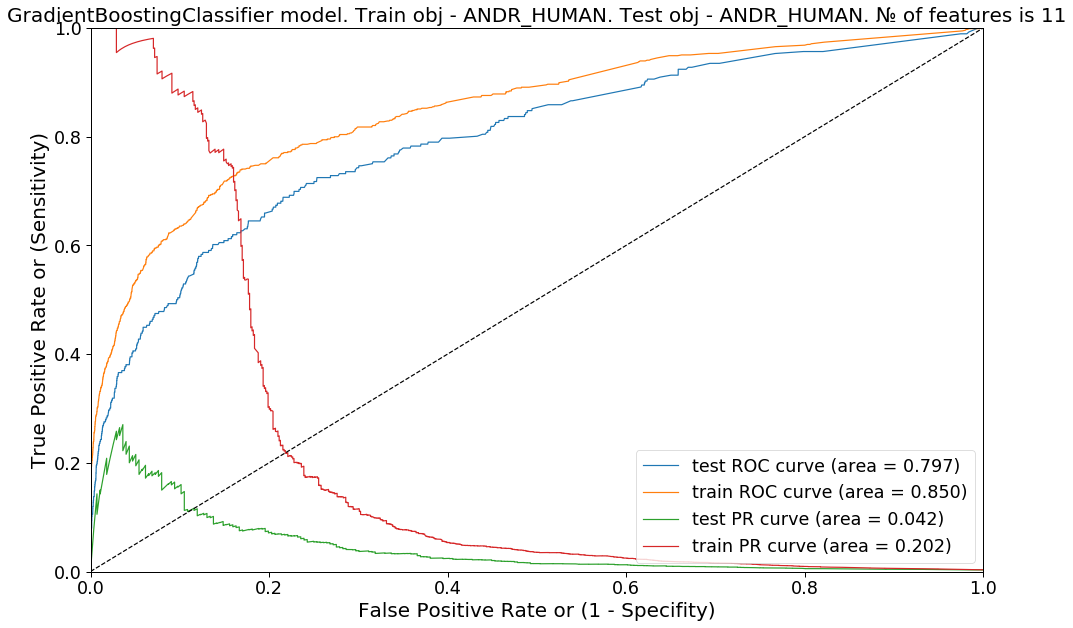

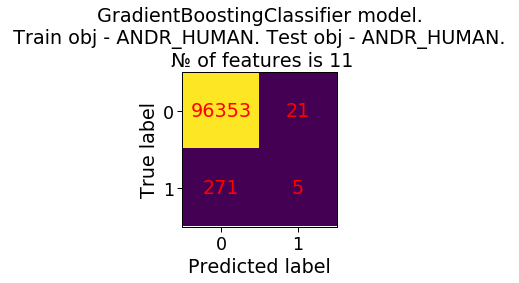

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033109.pics.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033110.gem.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033110.gem.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033110.macs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033110.macs.S.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_pics_M_feature_compare_table_cut.tab'] 16
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_co

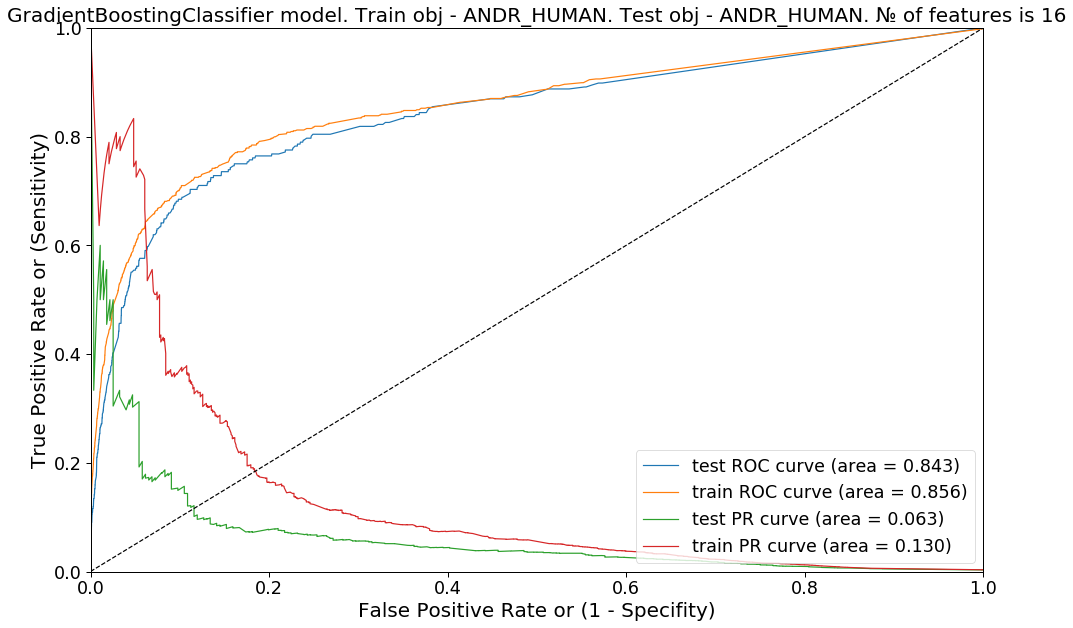

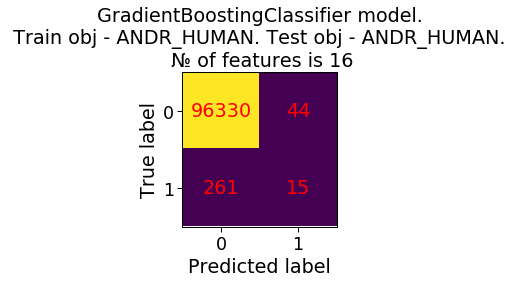

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033110.pics.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033110.pics.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033110.sissrs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033110.sissrs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033111.gem.M.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_pics_M_feature_compare_table_cut.tab'] 21
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_featu

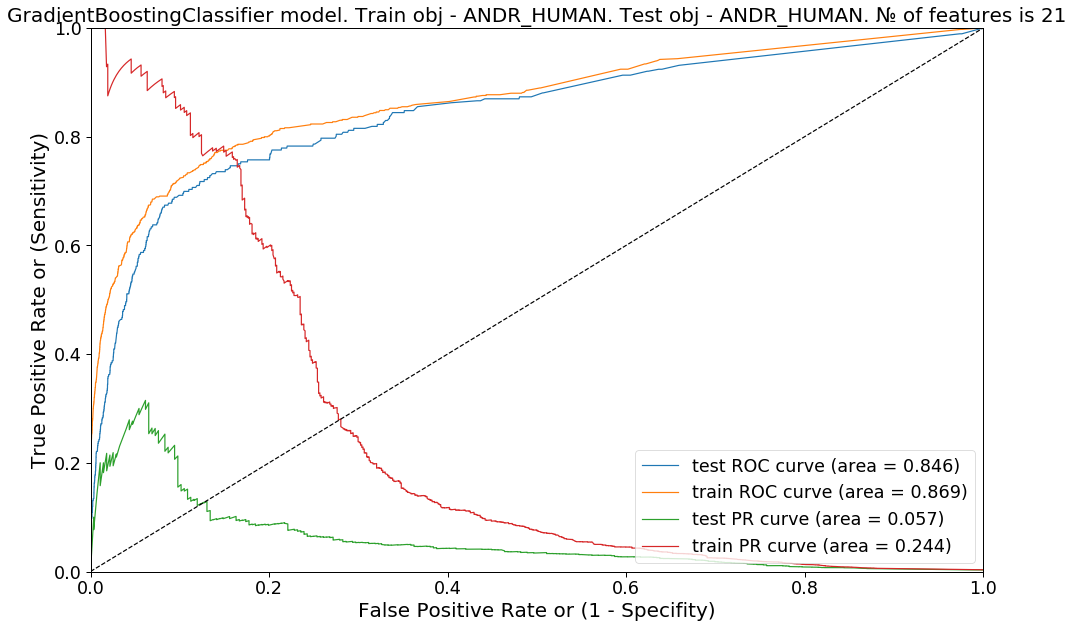

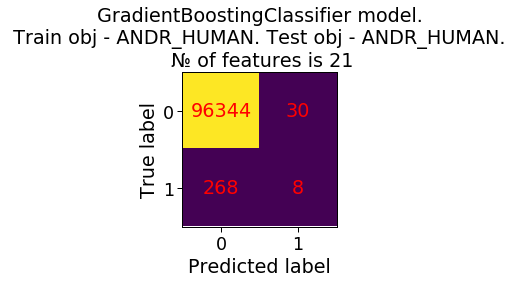

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033111.gem.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033111.macs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033111.macs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033111.pics.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033111.pics.S.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab'] 26
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_c

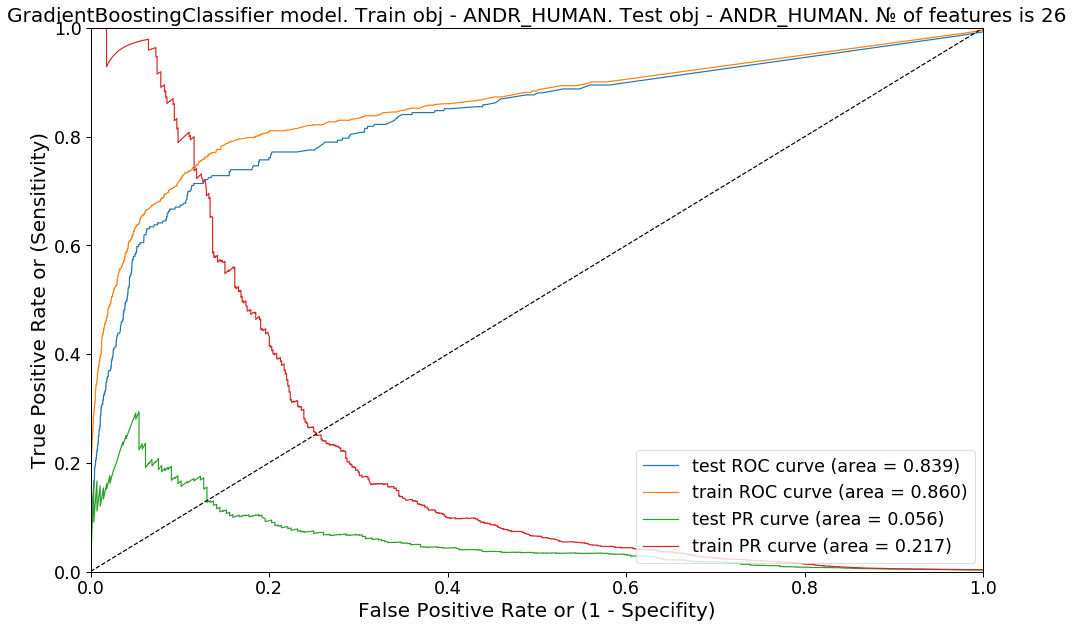

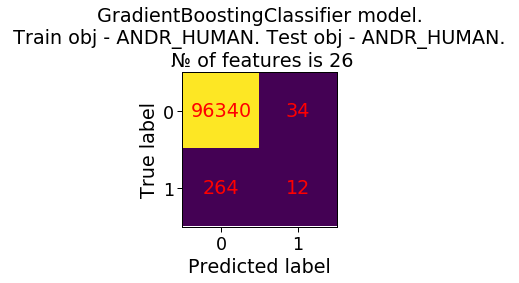

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033111.sissrs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033111.sissrs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033113.gem.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033113.gem.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033113.macs.M.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab'] 31
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_featur

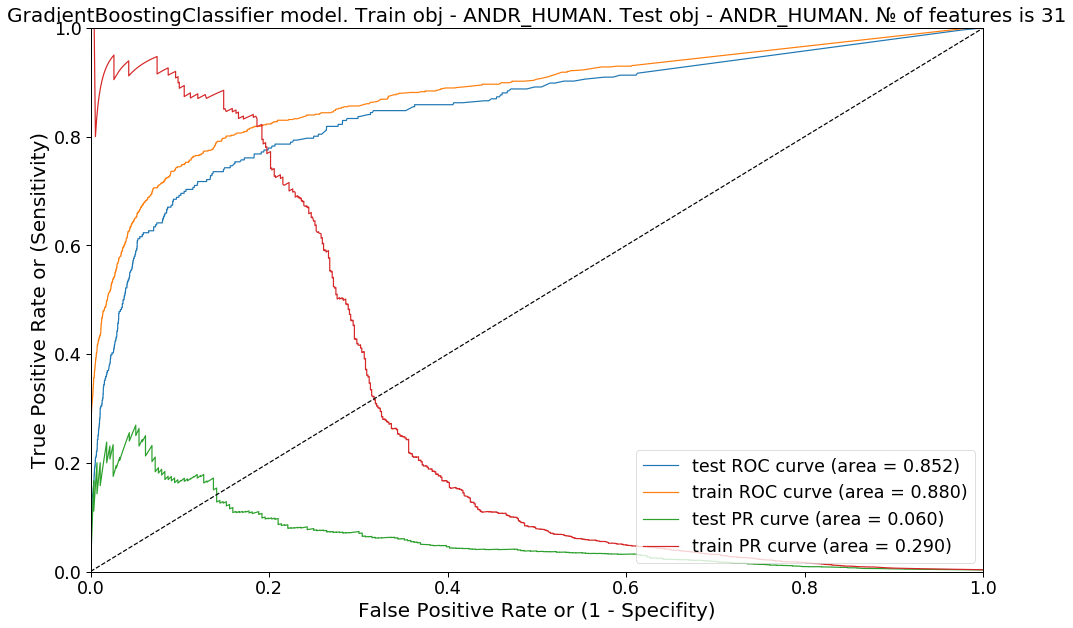

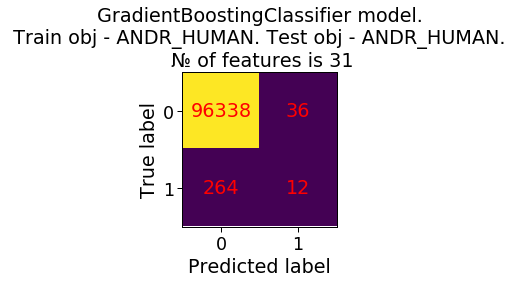

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033113.macs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033113.pics.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033113.pics.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033113.sissrs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033113.sissrs.S.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab'] 36
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feat

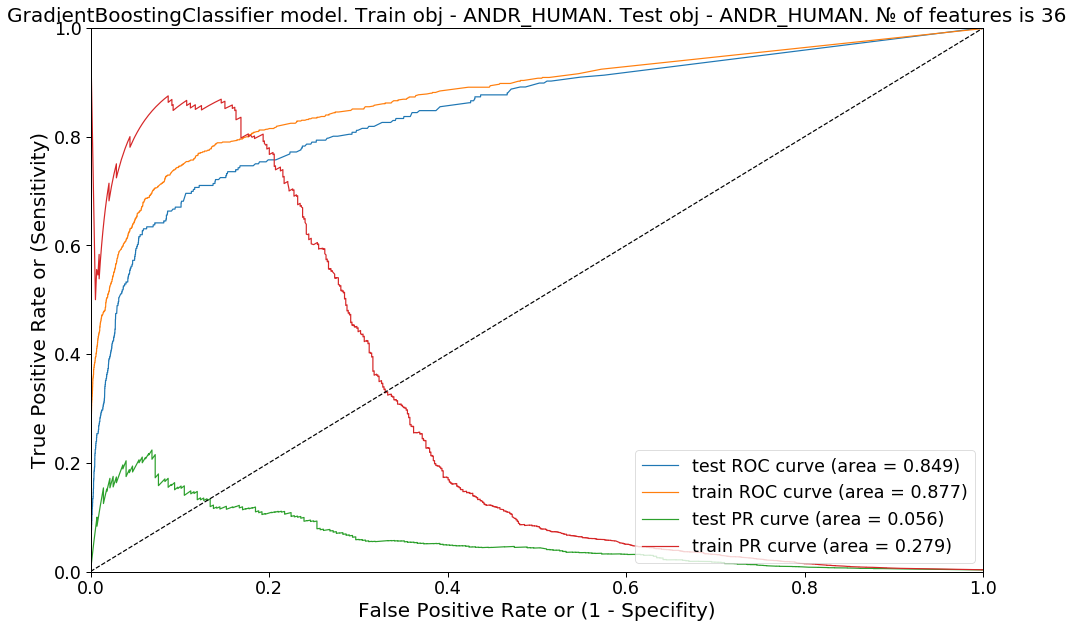

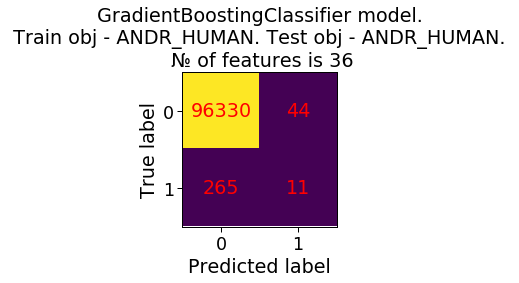

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033164.gem.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033164.gem.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033164.macs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033164.macs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033164.pics.M.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab'] 41
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_co

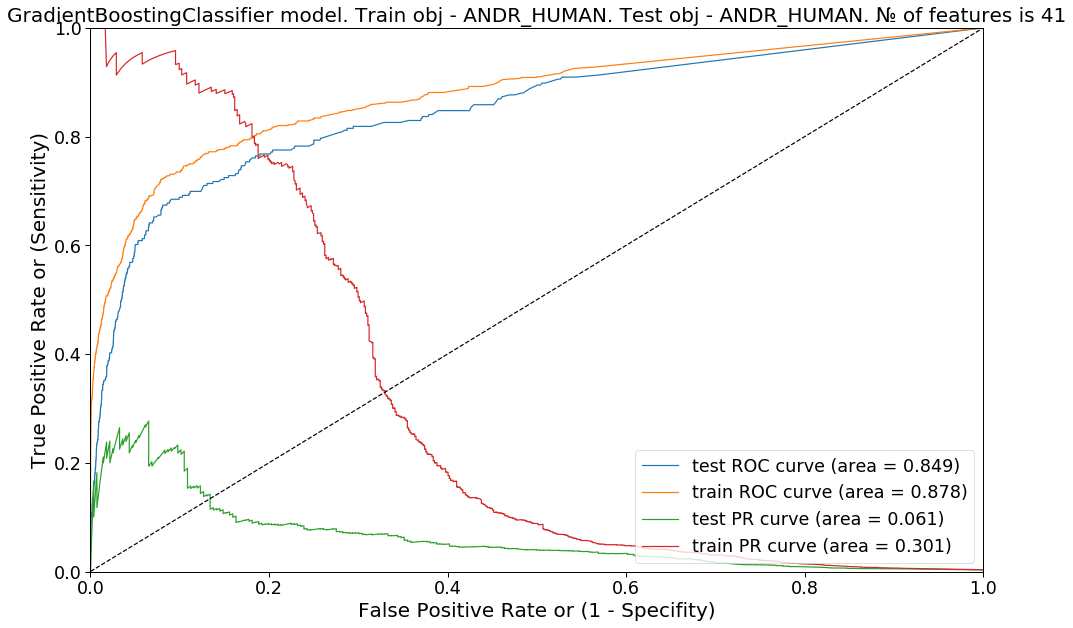

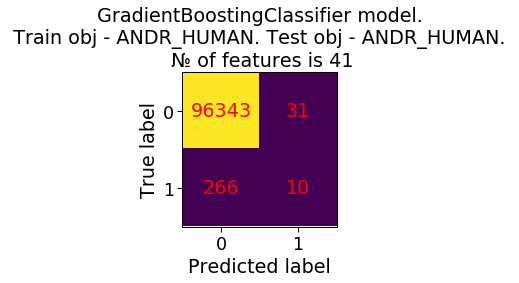

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033164.pics.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033164.sissrs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033164.sissrs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033248.gem.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033248.gem.S.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab'] 46
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_featur

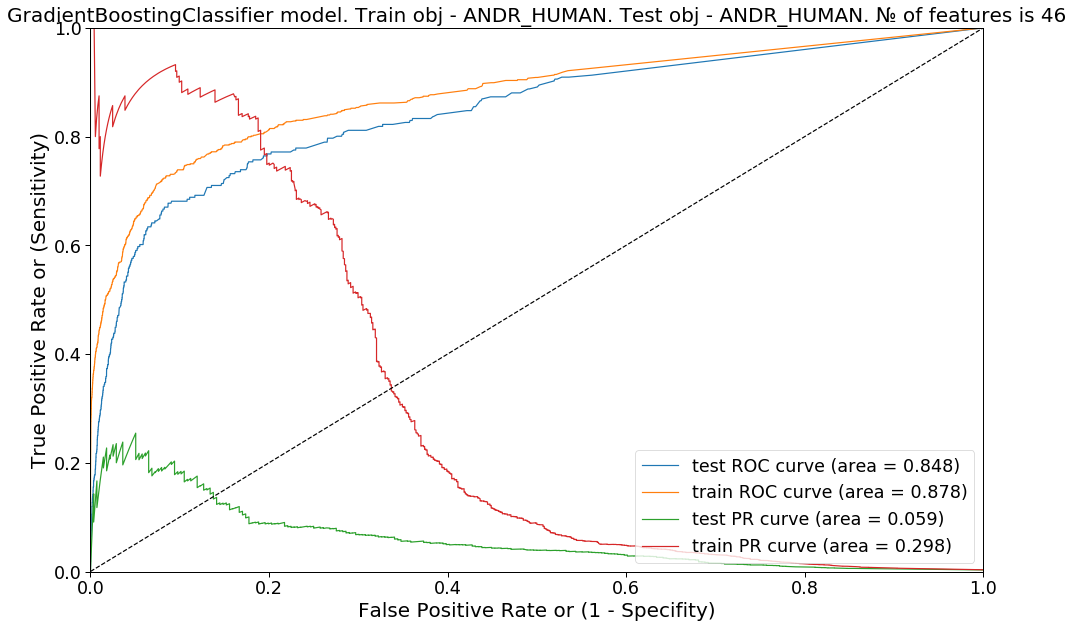

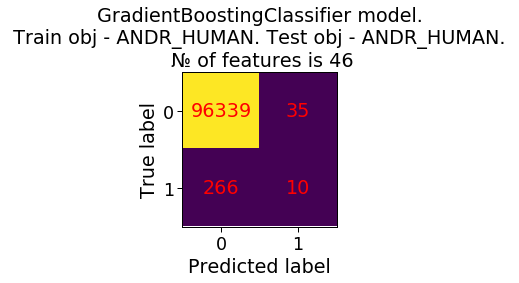

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033248.macs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033248.macs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033248.pics.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033248.pics.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033248.sissrs.M.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab'] 51
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_featur

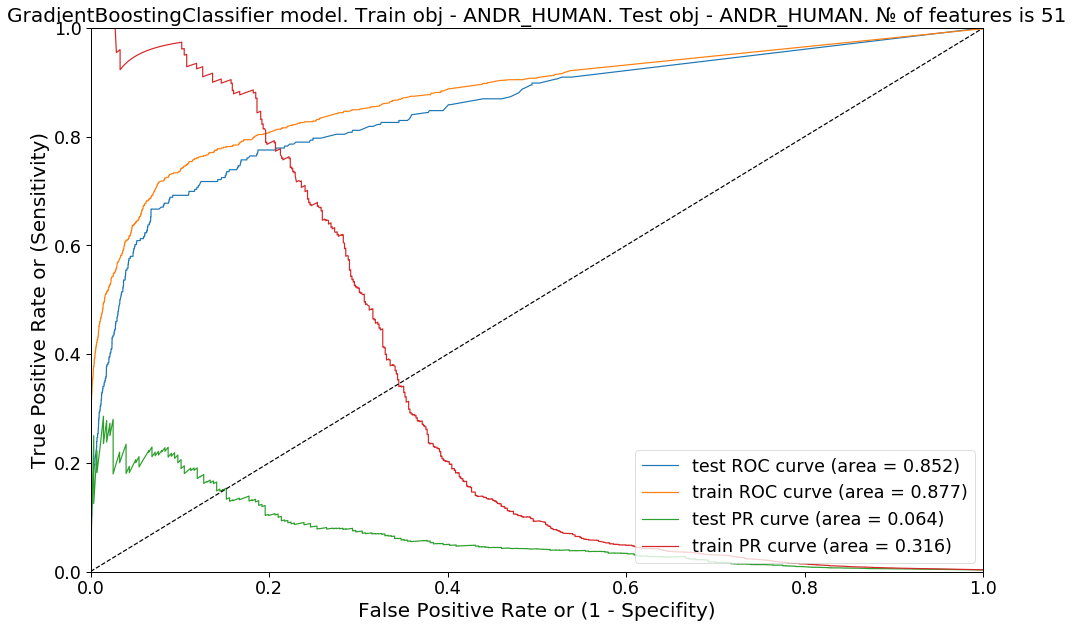

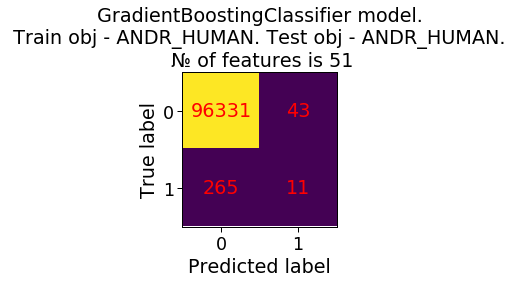

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033248.sissrs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033252.gem.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033252.gem.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033252.macs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033252.macs.S.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab'] 56
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_

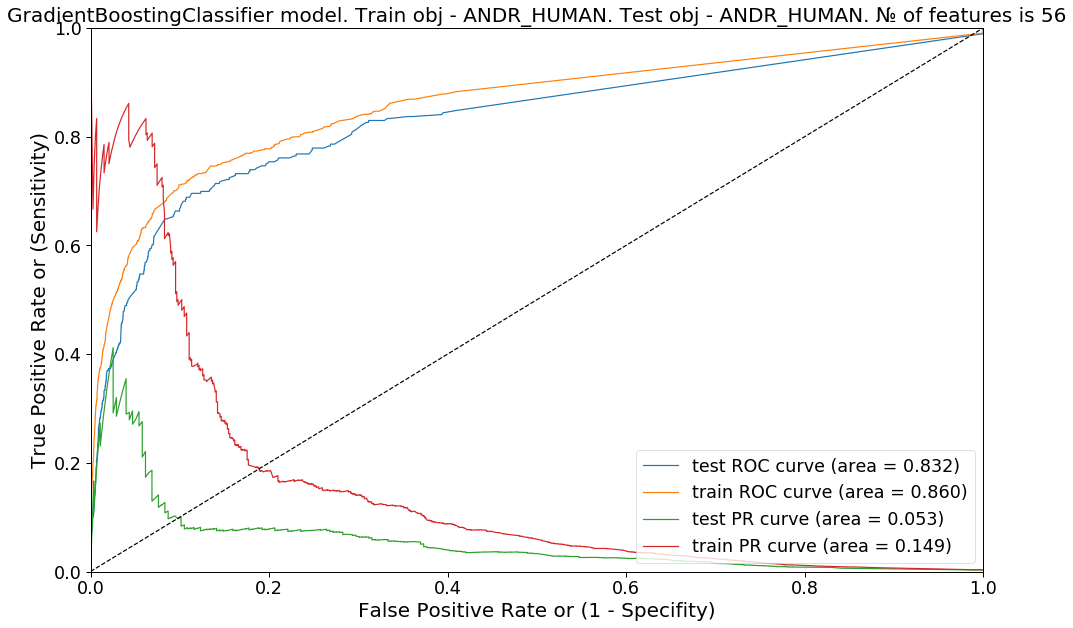

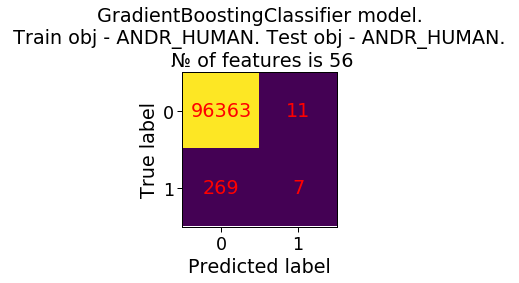

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033252.sissrs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033252.sissrs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033253.macs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033253.macs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033253.pics.M.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab'] 61
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feat

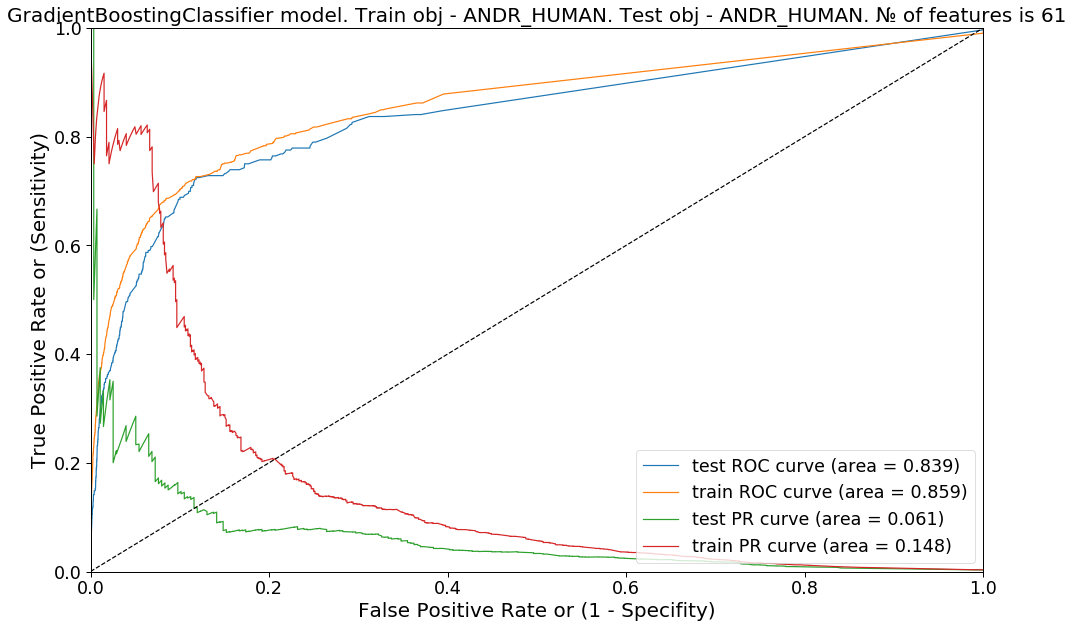

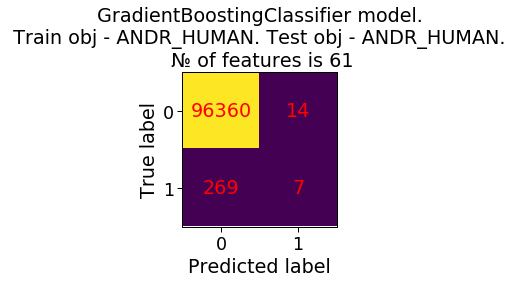

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033253.pics.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033253.sissrs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033253.sissrs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033319.macs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033319.macs.S.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab'] 66
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feat

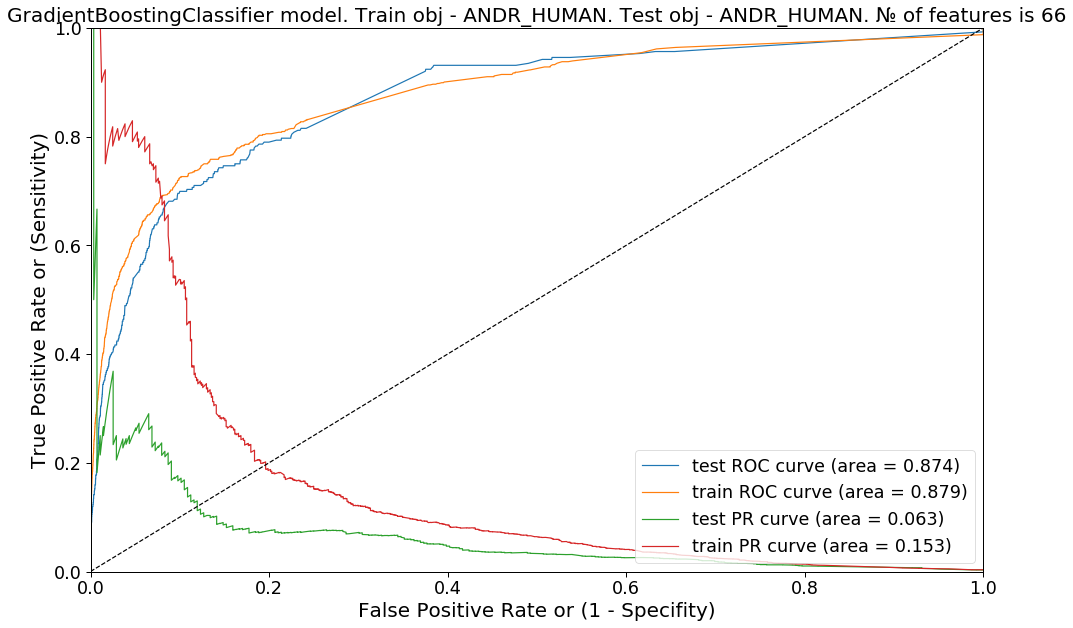

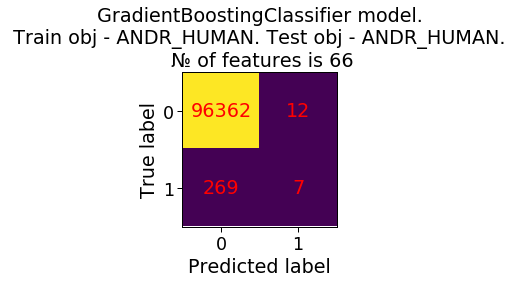

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033320.gem.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033320.gem.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033320.macs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033320.macs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033320.pics.M.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab'] 71
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_co

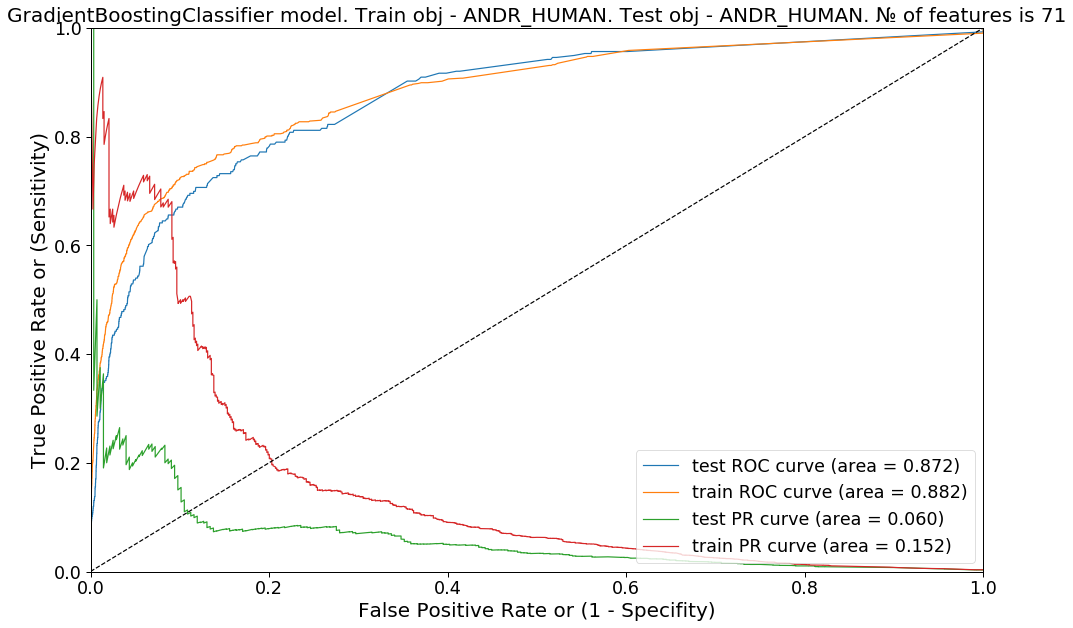

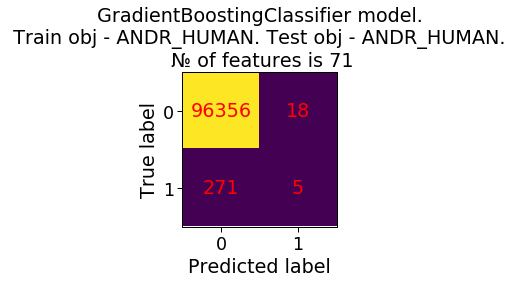

PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033320.pics.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033320.sissrs.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033320.sissrs.S.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033359.pics.M.pwm
PWM in process is: ANDR_HUMAN~CM~ANDR_HUMAN.PEAKS033359.pics.S.pwm
['ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033110_macs_S_feature_compare_table_cut.tab', 'ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_S_feature_compare_table_cut.tab'] 76
paste <( cut -f 1-3 ../../out.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_macs_S_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033111_pics_M_feature_compare_table_cut.tab ) <( cut -f 1 ANDR_HUMAN~CM~ANDR_HUMAN_PEAKS033090_macs_M_feat

KeyboardInterrupt: 

In [31]:
import subprocess, threading


class Command(object):
    def __init__(self, cmd):
        self.cmd = cmd
        self.process = None

    def run(self, timeout):
        def target():
            print('Thread started')
            self.process = subprocess.Popen(self.cmd, shell=True)
            self.process.communicate()
            print('Thread finished')

        thread = threading.Thread(target=target)
        thread.start()

        thread.join(timeout)
        if thread.is_alive():
            print('Terminating process')
            self.process.terminate()
            thread.join()
        print(self.process.returncode)

        
def group_selection(TF_name, df):     # сделать отсев по белковому семейству
    print("group_selection is running for", TF_name)
    
    train_pos = ["_".join(x) == TF_name for x in df[df.columns[1]].str.split('_').str[:2]]
    train_pos = df[train_pos]
    train_neg = np.array(["_".join(x) != TF_name for x in df[df.columns[1]].str.split('_').str[:2]])
    train_neg = df[train_neg]

    arr1 = [1] * train_pos.shape[0]
    df1 = train_pos.assign(ind=arr1)

    arr2 = [0] * train_neg.shape[0]
    df2 = train_neg.assign(ind=arr2)

    print(len(arr1),len(arr2))

    result = pd.concat([df1, df2])
    #print(result.head(100))
    return result


def data_splitting(result):
    print("data_splitting is running")
    X, Y = result.iloc[:,3:-1], result["ind"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,  test_size = 0.3, random_state = 1)
    print(X.shape, Y.shape)
    print(X_train.shape, X_test.shape)
    print(Y_train.shape, Y_test.shape)
    return X, Y, X_train, X_test, Y_train, Y_test
    
    
def model_building(X, Y, X_train, X_test, Y_train, Y_test):   
    print("model_building is running")
    sys.setrecursionlimit = 10**3

    n_estimators = 100
    GB = GradientBoostingClassifier(random_state=1, n_estimators=n_estimators)
    GB.fit(X_train, Y_train)
    y_pred = GB.predict(X_test)
    ascore=accuracy_score(Y_test,y_pred)
    pscore=precision_score(Y_test,y_pred)
    rscore=recall_score(Y_test,y_pred)
    matrix=confusion_matrix(Y_test,y_pred)
    print("Accuracy: %s" % '{:.2%}'.format(ascore))
    print ('Precision : %s' %'{:.2%}' .format(pscore))
    print ('Recall score: %s' % '{:.2%}'.format(rscore))
    Y_test_predicted_proba = GB.predict_proba(X_test)[:, 1]
    Y_train_predicted_proba = GB.predict_proba(X_train)[:, 1]
    print("roc_auc_score", roc_auc_score(y_score=Y_test_predicted_proba, y_true=Y_test))
    print("average_precision_score", average_precision_score(y_score=Y_test_predicted_proba, y_true=Y_test))
    return Y_test_predicted_proba, Y_train_predicted_proba, X, Y, X_train, X_test, Y_train, Y_test, matrix


def rocauc_plotting(Y_test_predicted_proba, Y_train_predicted_proba, X, Y, X_train, X_test, Y_train, Y_test, training_obj, testing_obj, features_c):
    print("rocauc_plotting is running")
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(16, 10)

    fpr_t, tpr_t, thresholds_t = roc_curve(Y_test, Y_test_predicted_proba)
    roc_auc_t = auc(fpr_t, tpr_t)
    plt.plot(fpr_t, tpr_t, label='test ROC curve (area = %0.3f)' % roc_auc_t)

    fpr, tpr, thresholds = roc_curve(Y_train, Y_train_predicted_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='train ROC curve (area = %0.3f)' % roc_auc)

    precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_predicted_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label='test PR curve (area = %0.3f)' % pr_auc)

    precision_t, recall_t, thresholds_t = precision_recall_curve(Y_train, Y_train_predicted_proba)
    pr_auc_t = auc(recall_t, precision_t)
    plt.plot(recall_t, precision_t, label='train PR curve (area = %0.3f)' % pr_auc_t)

    sns.set_context("paper", font_scale=2)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)', fontsize=20)
    plt.ylabel('True Positive Rate or (Sensitivity)', fontsize=20)
    plt.title('GradientBoostingClassifier model. Train obj - {training_obj}. Test obj - {testing_obj}. № of features is {N}'.format(N=features_c, training_obj=training_obj, testing_obj=testing_obj), fontsize=20)
    plt.legend(loc="lower right")
    plt.savefig('ROC_AUC_GradientBoostingClassifier_Train_{training_obj}_Test_{testing_obj}_{N}_features.png'.format(N=features_c, training_obj=training_obj, testing_obj=testing_obj), dpi=100)
    plt.show()
    
    line_f = 'echo {features_c} {roc_auc} {pr_auc} {roc_auc_t} {pr_auc_t} >> log_pr.txt'.format(features_c=features_c, 
                                                                                            roc_auc=roc_auc, 
                                                                                            pr_auc=pr_auc,
                                                                                            roc_auc_t=roc_auc_t,
                                                                                            pr_auc_t=pr_auc_t)
    p = subprocess.Popen(line_f, shell=True)
    p.wait()
    
    
def table_plot(matrix, training_obj, testing_obj, features_c):
    x_ax = ["0", "1"]
    y_ax = ["0", "1"]

    harvest = np.array(matrix)

    fig, ax = plt.subplots()
    im = ax.imshow(matrix)

    ax.set_xticks(np.arange(len(x_ax)))
    ax.set_yticks(np.arange(len(y_ax)))
    ax.set_xticklabels(x_ax)
    ax.set_yticklabels(y_ax)

    for i in range(len(y_ax)):
        for j in range(len(x_ax)):
            text = ax.text(j, i, harvest[i, j],
                           ha="center", va="center", color="r")
    
    plt.title('GradientBoostingClassifier model.\n Train obj - {training_obj}. Test obj - {testing_obj}. \n № of features is {N}'.format(N=features_c, training_obj=training_obj, testing_obj=testing_obj))

    fig.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig('Table_GradientBoostingClassifier_Train_{training_obj}_Test_{testing_obj}_{N}_features.png'.format(N=features_c, training_obj=training_obj, testing_obj=testing_obj), dpi=100)
    plt.show()
    
def global_builder(TF, new_dir_name):
    temp_result = [f for f in os.listdir(new_dir_name) if os.path.splitext(f)[1] == '.tab']
    print(temp_result[:5], len(temp_result))
        
    features_c = len(temp_result)
        
    !rm out_sure.csv
    string = "paste <( cut -f 1-3 ../../out.tab )"
    for fn in temp_result:
        string += ' <( cut -f 1 {file_name} )'.format(file_name=fn)
    string += ' >> out_sure.csv'
    print(string)

    with open("code.sh", "w") as f:
        f.write(string)
    !bash code.sh

    df = pd.read_csv(new_dir_name + "/" + "out_sure.csv", header=None, sep='\t')
    #print(df.head(10))
        
    result = group_selection(TF, df) # тяжелая конструкция. Внимание!:)
    X, Y, X_train, X_test, Y_train, Y_test = data_splitting(result)
    Y_test_predicted_proba, Y_train_predicted_proba, X, Y, X_train, X_test, Y_train, Y_test, matrix = model_building(X, Y, X_train, X_test, Y_train, Y_test)
    rocauc_plotting(Y_test_predicted_proba, Y_train_predicted_proba, X, Y, X_train, X_test, Y_train, Y_test, TF, TF, features_c)
    table_plot(matrix, TF, TF, features_c)

N_features = 200 
def sarus(outputdir, selected_full_names_list, selected_HUMAN, selected_MOUSE, pwmdir, N_features):
    print("Sarus is running...")
    print("Selected_full_names_list:", len(selected_full_names_list))
    сalc = 0
    for TF in selected_full_names_list: # выбираем ТФ -> выбираем последовательности
        print("factor # {сalc} of {all_c}".format(all_c=len(selected_full_names_list), сalc=сalc))
        сalc += 1
        try: 
            print(" ")
            print("dirname is:", TF)
            dir_list = os.listdir(pwmdir + "/" + TF)  # выбираем матицы для него же
            print(dir_list[:5])
        
            new_dir_name = outputdir + "/HUMAN_HUMAN_GB_tmp" + "/" + TF + "_" + TF # так как тест для того же ТФ
            if not os.path.exists(new_dir_name):
                os.makedirs(new_dir_name)
            os.chdir(new_dir_name)
        
            c = 0
            for matrix in dir_list:
                print("PWM in process is:", matrix)
                temp_result = [f for f in os.listdir(new_dir_name) if os.path.splitext(f)[1] == '.png']
                if N_features/5*2 > len(temp_result) and len(temp_result) < len(dir_list)/5*2:
                    line = 'java -Xmx2G -cp {sarsus_home} ru.autosome.SARUS {mfa_file} {matrix} --skipn --show-non-matching --output-scoring-mode score besthit | grep -v \> > {out_file}'.format(sarsus_home = root + "/sarus/releases/sarus-2.0.1.jar",
                    mfa_file = '/'.join([basicdir, "all_mfa_indexing_file_no_NF.fasta"]),
                    matrix = '/'.join([pwmdir, TF, matrix]),
                    out_file = '/'.join([new_dir_name, "_".join(matrix.split(".")[:-1]) + "_feature_compare_table.tab"]))
                    #print(line)
                    p = subprocess.Popen(line, shell=True)
                    p.wait()
                    
                    
                    !rm tmp.sh
                    line1 = "awk -F. \'{print $1\".\"substr($2,1,2)}\' " + "_".join(matrix.split(".")[:-1]) + "_feature_compare_table.tab" + " > " + "_".join(matrix.split(".")[:-1]) + "_feature_compare_table_cut.tab"
                    line2 = "rm " + "_".join(matrix.split(".")[:-1]) + "_feature_compare_table.tab"
                    with open("tmp.sh", "w") as f:
                        f.write(line1)
                        f.write(" ; ")
                        f.write(line2)
                    !bash tmp.sh
                    
                    if c%5 == 0:
                        global_builder(TF, new_dir_name)
                            
                    c += 1
                else:
                    break
                    
            #global_builder(TF, new_dir_name)
            !tar -cvzf features_files.tar.gz *.tab
            os.chdir(outputdir)
        except ValueError:
            print("")
            print("")
            print("!!!!!!!!!!!!!!!!!!!!ValueError found!!!!!!!!!!!!!!!!!!!!!")
            print("")
            print("")
            continue
            
    
sarus(outputdir, selected_full_names_list, selected_HUMAN, selected_MOUSE, pwmdir, N_features)
